In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import pandas as pd
import pybedtools as pbed
import os
import math
import statistics
import concurrent.futures

os.makedirs("/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools/", exist_ok = True)
pbed.helpers.set_tempdir("/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools/")
bed_genome_file = "/mnt/iusers01/jw01/mdefscs4/hg38.genome"

In [2]:
import sys
sys.path.append("..")
from configuration import Config

In [3]:
Configuration = Config()

In [4]:
tss_sites = "/mnt/iusers01/jw01/mdefscs4/psa_functional_genomics/NEW_references/genes/gencode.v29.TSS_sites_protein_coding_sorted.bed"

In [5]:
tss_bed = pbed.BedTool(tss_sites)
tss_bed = tss_bed.slop(b=2000,g=bed_genome_file)

In [6]:
def calculate_FRiP(tss_bed, genrich, macs, bam_file):
    bam_bed = pbed.BedTool(bam_file)
    reads_in_tss = bam_bed.intersect(tss_bed,bed=True,u=True).fn
    reads_in_macs = bam_bed.intersect(macs,bed=True,u=True).fn
    reads_in_genrich = bam_bed.intersect(genrich,bed=True,u=True).fn
    reads_in_tss = !wc -l $reads_in_tss
    reads_in_macs = !wc -l $reads_in_macs
    reads_in_genrich = !wc -l $reads_in_genrich
    reads_in_tss = int(reads_in_tss[0].split(" ")[0])
    reads_in_macs = int(reads_in_macs[0].split(" ")[0])
    reads_in_genrich = int(reads_in_genrich[0].split(" ")[0])
    tmp = !samtools view -c $bam_bed.fn
    total_reads = int(tmp[0])
    return reads_in_tss/total_reads, reads_in_macs/total_reads, reads_in_genrich/total_reads

def call_frip(sample):
    return calculate_FRiP(tss_bed, 
                          pbed.BedTool(os.path.join(Configuration.genrich_dir,sample,sample + "_genrich.bed")), 
                          pbed.BedTool(os.path.join(Configuration.macs2_dir,sample,sample + "_peaks.narrowPeak")), 
                          os.path.join(Configuration.cleaned_alignments_dir,sample,sample + "_align_dedup.bam"))

In [7]:
results = []
files = ['PsA4947_CD8_ATAC',
 'NRHV321_CD8_ATAC',
 'NRHV151_CD8_ATAC',
 'NRHV151_CD4_ATAC',
 'PsA4949_CD4_ATAC',
 'NRHV321_CD4_ATAC',
 'PsA4948_CD8_ATAC',
 'PsA4954_CD8_ATAC',
 'PsA4945_CD8_ATAC',
 'PsA4963_CD8_ATAC',
 'PsA4953_CD8_ATAC',
 'PsA4960_CD8_ATAC',
 'PsA4944_CD4_ATAC',
 'PsA4920_CD4_ATAC']
with concurrent.futures.ProcessPoolExecutor() as executor:
        for i, res in zip(files, executor.map(call_frip,files)):
            print(i, f"reads in tss: {res[0]:.2f}, reads in macs peaks {res[1]:.2f}, reads in genrich peaks {res[2]:.2f}")
            results.append(res)

PsA4947_CD8_ATAC reads in tss: 0.19, reads in macs peaks 0.23, reads in genrich peaks 0.33
NRHV321_CD8_ATAC reads in tss: 0.10, reads in macs peaks 0.10, reads in genrich peaks 0.17
NRHV151_CD8_ATAC reads in tss: 0.31, reads in macs peaks 0.37, reads in genrich peaks 0.52
NRHV151_CD4_ATAC reads in tss: 0.27, reads in macs peaks 0.34, reads in genrich peaks 0.47
PsA4949_CD4_ATAC reads in tss: 0.13, reads in macs peaks 0.15, reads in genrich peaks 0.22
NRHV321_CD4_ATAC reads in tss: 0.06, reads in macs peaks 0.05, reads in genrich peaks 0.11
PsA4948_CD8_ATAC reads in tss: 0.16, reads in macs peaks 0.17, reads in genrich peaks 0.28
PsA4954_CD8_ATAC reads in tss: 0.23, reads in macs peaks 0.28, reads in genrich peaks 0.41
PsA4945_CD8_ATAC reads in tss: 0.20, reads in macs peaks 0.22, reads in genrich peaks 0.35
PsA4963_CD8_ATAC reads in tss: 0.18, reads in macs peaks 0.24, reads in genrich peaks 0.34
PsA4953_CD8_ATAC reads in tss: 0.33, reads in macs peaks 0.44, reads in genrich peaks 0.59

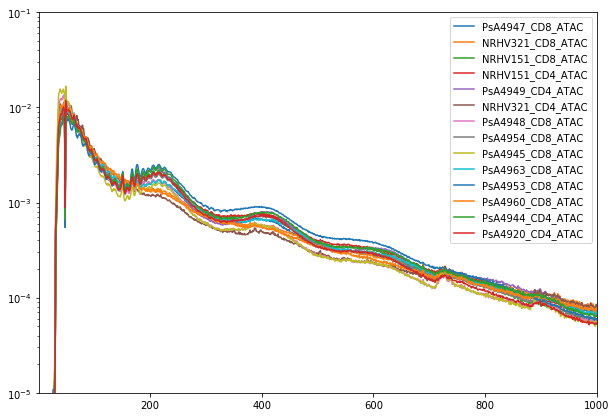

In [8]:
plt.figure(figsize=(10,7))
for sample in files:
    data = pd.read_csv(os.path.join(Configuration.other_qc_dir,sample,sample + "_fragment_length_count.txt"), sep = " ",header=None)
    plt.plot(data[1],data[0]/sum(data[0]), label = sample)
    plt.xlim(1,1000)
    plt.ylim(1e-5,1e-1)
    plt.yscale("log")
    plt.legend()